In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import os
from openai import OpenAI

client = OpenAI(base_url=os.getenv("URL"), api_key=os.getenv("KEY"))

In [ ]:
from src.agents import EvaluationAgent

eval_agent = EvaluationAgent(client=client)

In [ ]:
import json
import random

with open("../benchmarks/satisfactory_recipes_benchmark.json", "r") as f:
    satisfactory_recipes_benchmark = json.load(f)

random.shuffle(satisfactory_recipes_benchmark)

print(len(satisfactory_recipes_benchmark))
print(
    f"Yes: {100 * sum([r['answer'] == 'Yes' for r in satisfactory_recipes_benchmark]) / len(satisfactory_recipes_benchmark)}%"
)
print(
    f"No: {100 * sum([r['answer'] == 'No' for r in satisfactory_recipes_benchmark]) / len(satisfactory_recipes_benchmark)}%"
)

120
Yes: 57.5%
No: 42.5%


In [ ]:
def test_eval_agent(examples):
    correct = 0
    incorrect = []

    for example in examples:
        response = eval_agent.say(example["recipe"], example["request"])

        if response == example["answer"]:
            correct += 1
        else:
            incorrect.append((example, response))

    return correct, incorrect


eval_correct, eval_incorrect = test_eval_agent(satisfactory_recipes_benchmark)
print(f"Accuracy: {100 * eval_correct / len(satisfactory_recipes_benchmark):.2f}%")

for question, eval_answer in eval_incorrect:
    print(f"Question: {question['request']}")
    print(f"Recipe: {question['recipe']}")
    print(f"Correct Answer: {question['answer']}")
    print(f"Evaluation Agent Answer: {eval_answer}")

Accuracy: 99.17%
Question: Can you share a vegan pasta recipe?
Recipe: Ingredients: 200g spaghetti, 2 cups tomato sauce, 1 cup mushrooms, 1 cup spinach, 2 tbsp olive oil. Instructions: Cook spaghetti. Sauté mushrooms and spinach in olive oil. Mix with tomato sauce and serve.
Correct Answer: Yes
Evaluation Agent Answer: No


In [ ]:
from src.tools import query_vectordb, substitution_filter, scrape_web_recipe, access_memory
from src.agents import RecipeAgent
from src.datatypes import ToolDescription

In [ ]:
tools = [
    ToolDescription(
        name="query_vectordb",
        signature="query_vectordb(query: str, n_results=1)",
        description="This function searches a vector database for recipes similar to the query argument.",
        example_json='Call query_vectordb:\n```json\n{\n"query": "banana bread recipe"\n}\n```',
        function=query_vectordb,
    ),
    ToolDescription(
        name="substitution_filter",
        signature="substitution_filter(to_replace: list[str])",
        description=(
            "This function searches for alternatives required given a list of ingredients"
            " that are necessary to change based on the user's restrictions. Only provide the ingredients to substitute as the argument."
        ),
        example_json='Call substitution_filter:\n```json\n{\n"to_replace": ["eggs", "flour"]\n}\n```',
        function=substitution_filter,
    ),
    ToolDescription(
        name="scrape_web_recipe",
        signature="scrape_web_recipe(link: str)",
        description="This function scrapes the recipe at the provided link as an argument. Use this when the user provides a link.",
        example_json='Call scrape_web_recipe:\n```json\n{\n"link": "https://www.allrecipes.com/lemon-garlic-butter"\n}\n```',
        function=scrape_web_recipe,
    ),
    ToolDescription(
        name="access_memory",
        signature="access_memory(query: str, n_results=1)",
        description="This function retrieves the most similar previous agent-user conversation for additional context.",
        example_json='Call access_memory:\n```json\n{\n"query": "eggless banana bread recipe"\n}\n```',
        function=access_memory,
    ),
]

In [ ]:
from openai import BadRequestError
from tqdm import tqdm

all_evals = []
errors = []

temperatures = [0.0, 0.1, 0.2]

for temp in temperatures:
    print("Temperature:", temp)
    recipe_agent = RecipeAgent(
        client=client, tools=tools, max_internal_iteration=3, temperature=temp
    )

    evaluations = []

    for example in tqdm(
        satisfactory_recipes_benchmark, desc=f"Processing at temp {temp:.2f}"
    ):
        try:
            recipe_agent.conversation = recipe_agent.conversation[:1]
            recipe_response, _ = recipe_agent.say(
                example["request"], add_to_memory=False
            )

            evaluation = eval_agent.say(
                recipe=recipe_response, criteria=example["request"]
            )
            evaluations.append(evaluation)
        except Exception as e:
            if type(e) is BadRequestError:
                evaluations.append("Context Window")
            else:
                evaluations.append("Other")

            errors.append(e)

    all_evals.append(evaluations)

Temperature: 0.0


Processing at temp 0.00:   0%|          | 0/120 [00:00<?, ?it/s]Add of existing embedding ID: 126cc7b5ccdb19680f7c16e9017dfaa6ed6a386c7513157abf0113a4ddd20e2d
Add of existing embedding ID: f4419a42ead631ace283b4ec62396499f3e55c44499dd625b92d64dcb1b71fe6
Add of existing embedding ID: 8c8ebc3e876f74558180eace9ff2f03a0f12bca521d6fb7b9e4b68678672f47c
Add of existing embedding ID: 2c22736ed1baae863a907849be6658248b9a2f0ce5edd5fe3d7987a756661263
Add of existing embedding ID: bee81c180bb558070437c0526a3f5fe26c7a5dafbccf0a2c7cfa7b3ed106dbfe
Add of existing embedding ID: 126cc7b5ccdb19680f7c16e9017dfaa6ed6a386c7513157abf0113a4ddd20e2d
Add of existing embedding ID: f4419a42ead631ace283b4ec62396499f3e55c44499dd625b92d64dcb1b71fe6
Add of existing embedding ID: 126cc7b5ccdb19680f7c16e9017dfaa6ed6a386c7513157abf0113a4ddd20e2d
Add of existing embedding ID: f4419a42ead631ace283b4ec62396499f3e55c44499dd625b92d64dcb1b71fe6
Add of existing embedding ID: 8c8ebc3e876f74558180eace9ff2f03a0f12bca521d6fb7b9e4

Temperature: 0.1


Processing at temp 0.10: 100%|██████████| 120/120 [14:59<00:00,  7.50s/it]


Temperature: 0.2


Processing at temp 0.20: 100%|██████████| 120/120 [15:11<00:00,  7.59s/it]


In [ ]:
for temp, agent_eval in zip(temperatures, all_evals):
    correct = 0
    incorrect = 0
    context_window = 0
    other = 0

    for i in agent_eval:
        if i == "Yes":
            correct += 1
        elif i == "No":
            incorrect += 1
        elif i == "Context Window":
            context_window += 1
        else:
            other += 1

    print(f"Temperature: {temp}")
    print(f"Correct: {(correct / len(agent_eval)) * 100}%")
    print(f"Incorrect: {(incorrect / len(agent_eval)) * 100}%")
    print(f"Context Window Issue: {(context_window / len(agent_eval)) * 100}%")
    print(f"Other: {(other / len(agent_eval)) * 100}%")
    print()

Temperature: 0.0
Correct: 69.16666666666667%
Incorrect: 26.666666666666668%
Context Window Issue: 4.166666666666666%
Other: 0.0%

Temperature: 0.1
Correct: 75.0%
Incorrect: 19.166666666666668%
Context Window Issue: 5.0%
Other: 0.8333333333333334%

Temperature: 0.2
Correct: 74.16666666666667%
Incorrect: 20.0%
Context Window Issue: 5.833333333333333%
Other: 0.0%



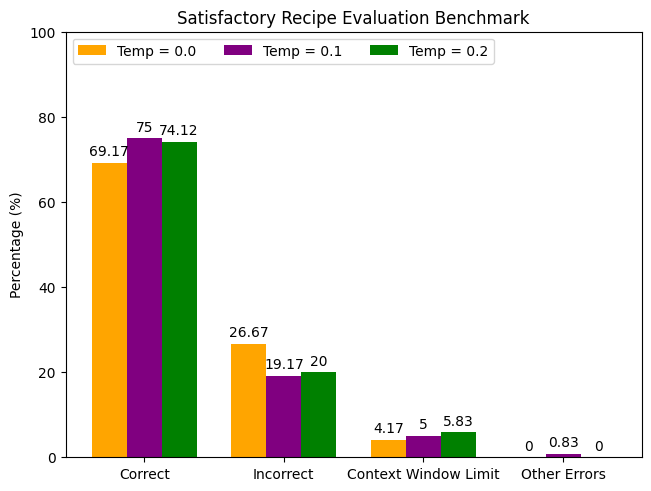

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Correct", "Incorrect", "Context Window Limit", "Other Errors"]
satisfactory_recipe_metrics = {
    "Temp = 0.0": [69.17, 26.67, 4.17, 0.0],  # Fixed the typo in the second list
    "Temp = 0.1": [75.0, 19.17, 5, 0.83],
    "Temp = 0.2": [74.12, 20, 5.83, 0.0],
}

# Custom colors for each temperature setting
colors = {"Temp = 0.0": "orange", "Temp = 0.1": "purple", "Temp = 0.2": "green"}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)  # Fixed the layout argument

# Plotting each metric with the specified colors
for attribute, measurement in satisfactory_recipe_metrics.items():
    offset = width * multiplier
    color = colors[attribute]
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel("Percentage (%)")
ax.set_title("Satisfactory Recipe Evaluation Benchmark")
ax.set_xticks(x + width, labels)  # Adjust the x-tick positions to match bar locations
ax.legend(loc="upper left", ncols=4)
ax.set_ylim(0, 100)  # Adjusted y-limit to 100 for percentage display

plt.show()

In [ ]:
pass_at_1 = 0
pass_at_2 = 0

recipe_agent = RecipeAgent(
    client=client, tools=tools, max_internal_iteration=3, temperature=0.1
)

for example in tqdm(satisfactory_recipes_benchmark):
    recipe_agent.conversation = recipe_agent.conversation[:1]
    try:
        recipe_response, _ = recipe_agent.say(example["request"], add_to_memory=False)
        evaluation = eval_agent.say(recipe=recipe_response, criteria=example["request"])
    except:
        evaluation = "Fail"

    if evaluation == "Yes":
        pass_at_1 += 1
        pass_at_2 += 1
    else:
        recipe_agent.conversation = recipe_agent.conversation[:1]
        try:
            recipe_response, _ = recipe_agent.say(
                example["request"], add_to_memory=False
            )
            evaluation = eval_agent.say(
                recipe=recipe_response, criteria=example["request"]
            )
        except:
            evaluation = "Fail"

        if evaluation == "Yes":
            pass_at_2 += 1

# Print pass@1 and pass@2 metrics
print(f"Pass@1: {pass_at_1}/{len(satisfactory_recipes_benchmark)}")
print(f"Pass@2: {pass_at_2}/{len(satisfactory_recipes_benchmark)}")

100%|██████████| 120/120 [19:29<00:00,  9.75s/it]

Pass@1: 84/120
Pass@2: 103/120


In [ ]:
print(f"Pass@1: {100 * pass_at_1 / len(satisfactory_recipes_benchmark)}%")
print(f"Pass@2: {100 * pass_at_2 / len(satisfactory_recipes_benchmark)}%")

Pass@1: 70.0%
Pass@2: 85.83333333333333%


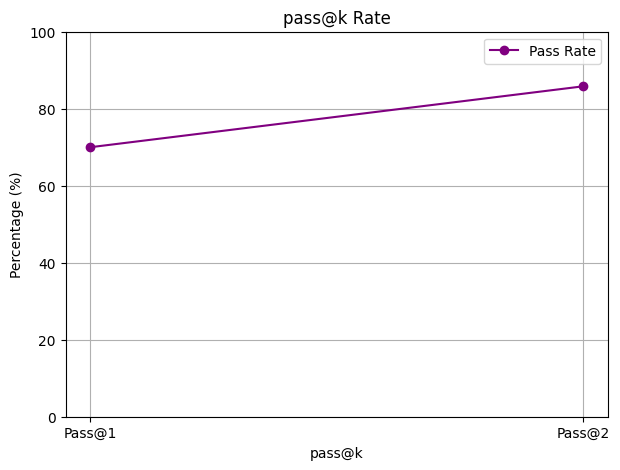

In [ ]:
import matplotlib.pyplot as plt

# Data for the line plot
x = ["Pass@1", "Pass@2"]
y = [70.0, 85.83]

# Plotting the line graph
plt.figure(figsize=(7, 5))
plt.plot(x, y, marker="o", linestyle="-", color="purple", label="Pass Rate")
plt.title("pass@k Rate")
plt.xlabel("pass@k")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)  # Set y-axis to range from 0% to 100%
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import json
import random

with open("../benchmarks/tools_benchmark.json", "r") as f:
    tools_benchmark = json.load(f)

random.shuffle(tools_benchmark)

In [11]:
len(tools_benchmark)

55

In [ ]:
from tqdm import tqdm
from src.datatypes import ToolResponse

steps_correct = []

recipe_agent = RecipeAgent(
    client=client, tools=tools, max_internal_iteration=3, temperature=0.1
)

for question in tqdm(tools_benchmark, total=len(tools_benchmark)):
    recipe_agent.conversation = recipe_agent.conversation[:1]

    try:
        _, response_steps = recipe_agent.say(question["prompt"], add_to_memory=False)

        tool_steps = filter(lambda step: isinstance(step, ToolResponse), response_steps)
        tool_names = set([i.tool_name for i in tool_steps])

        intersection = tool_names.intersection(set(question["expected_tools"]))
        steps_correct.append(len(intersection) / len(question["expected_tools"]))
    except:
        steps_correct.append(0.0)

 22%|██▏       | 12/55 [01:50<03:46,  5.27s/it]Add of existing embedding ID: 126cc7b5ccdb19680f7c16e9017dfaa6ed6a386c7513157abf0113a4ddd20e2d
Add of existing embedding ID: f4419a42ead631ace283b4ec62396499f3e55c44499dd625b92d64dcb1b71fe6
Add of existing embedding ID: 8c8ebc3e876f74558180eace9ff2f03a0f12bca521d6fb7b9e4b68678672f47c
Add of existing embedding ID: 2c22736ed1baae863a907849be6658248b9a2f0ce5edd5fe3d7987a756661263
Add of existing embedding ID: bee81c180bb558070437c0526a3f5fe26c7a5dafbccf0a2c7cfa7b3ed106dbfe
Add of existing embedding ID: 126cc7b5ccdb19680f7c16e9017dfaa6ed6a386c7513157abf0113a4ddd20e2d
Add of existing embedding ID: f4419a42ead631ace283b4ec62396499f3e55c44499dd625b92d64dcb1b71fe6
Add of existing embedding ID: 126cc7b5ccdb19680f7c16e9017dfaa6ed6a386c7513157abf0113a4ddd20e2d
Add of existing embedding ID: f4419a42ead631ace283b4ec62396499f3e55c44499dd625b92d64dcb1b71fe6
Add of existing embedding ID: 8c8ebc3e876f74558180eace9ff2f03a0f12bca521d6fb7b9e4b68678672f47c
Add

In [19]:
print(f"Average Correct Tool Steps: {100 * sum(steps_correct) / len(steps_correct)}%")

Average Correct Tool Steps: 68.18181818181819%


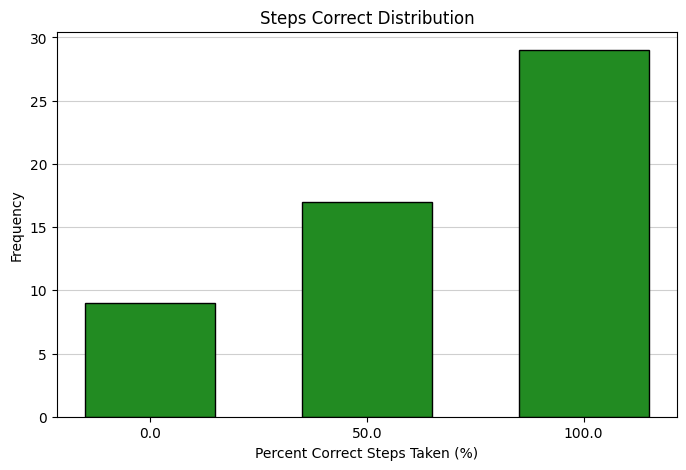

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

frequency = Counter(steps_correct)

x, y = zip(*sorted(frequency.items()))  # Sort by keys (x values)
x = [100 * i for i in x]
x_pos = range(len(x))  # Create evenly spaced positions for x-axis

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x_pos, y, color="forestgreen", edgecolor="black", width=0.6)  # Adjust bar width
ax.set_title("Steps Correct Distribution")
ax.set_xlabel("Percent Correct Steps Taken (%)")
ax.set_ylabel("Frequency")
ax.set_xticks(x_pos, labels=x)  # Label x-axis with the original keys
ax.grid(axis="y", linestyle="-", alpha=0.6, zorder=0)
ax.set_axisbelow(True)  # Ensure gridlines are below the bars
plt.show()